# BERT Sentiment classification with BERT model - ImDB dataset

Welcome in this notebook ! We are here to learn how to play with HuggingFace model. Let's begin with a simple application : sentiment classification with a BERT.


We use a BERT tokekenizer + BERT encoder and then train a classification MLP head on the top.

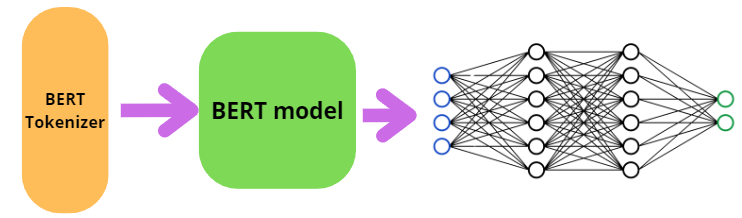

## Import

In [1]:
from transformers import BertForSequenceClassification, BertTokenizer
from datasets import load_dataset
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, RandomSampler, DataLoader
from torch.optim import AdamW
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

## Preprocessing

The IMDB dataset is a widely-used resource for sentiment classification tasks in natural language processing (NLP). It consists of 50,000 movie reviews from the Internet Movie Database (IMDB), evenly split into 25,000 training and 25,000 testing reviews. Each subset contains an equal number of positive (12,500) and negative (12,500) reviews, labeled with binary sentiment labels (positive: 1, negative: 0). The reviews are written in English and vary in length.

In [2]:
imdb = load_dataset("imdb")

Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at C:\Users\alexa\.cache\huggingface\datasets\imdb\plain_text\0.0.0\e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Thu Aug 15 00:53:41 2024).


In [8]:
imdb["train"]
imdb["test"]

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [3]:
BATCH_SIZE= 16
EPOCHS = 5
R1 = 0.8 #ratio train set
R2 = 0.9 # ratio (train+val) set

In [9]:
class Classifier() :
    """
    This class defines a text classifier based on a Bert Model.
    The architecture is composed of a Bert and an MLP head on the top.
    Here we instanciate it in order to perform a sentiment classification task. 
    """
    def __init__(self, tokenizer, optimizer, dataset, model) :
        """
        Inputs :\n
        tokenizer: the tokenizer used on a the text\n
        optimizer : the optimizer used for the training\n
        dataset : all data (train+test+val)\n
        model : instance of the pytorch model
        """
        self.tokenizer = tokenizer
        self.dataset = dataset
        self.optimizer = optimizer
        self.model = model

    def preprocess(self) :
        """
        
        """
        #Split
        train_val_ratio = self.dataset["train"].shape[0]*R1
        train = self.dataset["train"].iloc[:int(train_val_ratio)]
        val = self.dataset["train"].iloc[int(train_val_ratio):]
        test = self.dataset["test"]

        #Tokenize
        train_tk = self.tokenizer(list(train["text"]), padding=True, return_tensors="pt", truncation=True)
        val_tk = self.tokenizer(list(val["text"]), padding=True, return_tensors="pt", truncation=True)
        test_tk = self.tokenizer(list(test["text"]), padding=True, return_tensors="pt", truncation=True)

        #TensorDataset 
        train_tensor = TensorDataset(train_tk["input_ids"], train_tk["attention_mask"], torch.tensor(train["label"].values))
        val_tensor = TensorDataset(val_tk["input_ids"], val_tk["attention_mask"], torch.tensor(val["label"].values))
        test_tensor = TensorDataset(test_tk["input_ids"], test_tk["attention_mask"], torch.tensor(test["label"].values))

        #DataLoader
        self.train_dataloader = DataLoader(train_tensor, sampler=RandomSampler(train_tensor), batch_size=BATCH_SIZE)
        self.val_dataloader = DataLoader(val_tensor, sampler=RandomSampler(val_tensor), batch_size=BATCH_SIZE)
        self.test_dataloader = DataLoader(test_tensor, sampler=RandomSampler(test_tensor), batch_size=BATCH_SIZE)

#One training epoch
    def one_epoch_train(self, epoch, device) :
        self.model.train()
        train_loss = 0
        for batch in self.train_dataloader :
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            self.optimizer.zero_grad()
            outputs = self.model(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
            loss = outputs.loss
            loss.backward()

            self.optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(self.train_dataloader)
        print(f"Epoch {epoch + 1}/{EPOCHS} - Training loss: {avg_train_loss}")
        self.train_loss.append(avg_train_loss)

#One validation epoch
    def one_epoch_val(self, epoch, device) :
        self.model.eval()
        eval_loss = 0
        with torch.no_grad() :
            for batch in self.val_dataloader :
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device)

                outputs = self.model(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
                loss = outputs.loss
                
                eval_loss += loss.item()
        avg_eval_loss = eval_loss / len(self.val_dataloader)
        print(f"Epoch {epoch + 1}/{EPOCHS} - Validation loss: {avg_eval_loss}")
        self.val_loss.append(avg_eval_loss)

#One test epoch
    def one_epoch_test(self, epoch, device) :
        self.model.eval()
        with torch.no_grad() :
            for batch in self.test_dataloader :
                input_ids = batch[0].to(device)
                attention_mask = batch[0].to(device)
                labels = batch[2].to(device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)


    def train(self) :
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        self.train_loss = []
        self.val_loss = []
        for epoch in range(EPOCHS) :
            self.one_epoch_train(epoch, device)
            self.one_epoch_val(epoch, device)

    def graph(self) :
        fig, axes = plt.subplots(1,2, figsize=(10,7))
        plt.suptitle("Loss graph")
        axes[0].plot(range(EPOCHS), self.train_loss)
        axes[0].set_title("Train loss")
        axes[0].set_xlabel("epoch")
        axes[0].set_ylabel("training loss")

        axes[1].plot(range(EPOCHS), self.val_loss)
        axes[1].set_title("validation loss")
        axes[1].set_xlabel("epoch")
        axes[1].set_ylabel("validation loss")
        
    def metrics(self) :
        self.model.eval()
        predictions = []
        labels = []
        pass

        #F1-score
        #Confusion matrix + recall + accuracy

In [14]:
train = pd.DataFrame(imdb["train"])[:10]
test = pd.DataFrame(imdb["test"])[:10]

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
optimizer = AdamW(model.parameters(), lr=10e-5)
data = imdb.iloc[:10]
cls = Classifier(tokenizer, optimizer, data, model)

In [55]:
cls.preprocess()

In [56]:
cls.train()

Epoch 1/5 - Training loss: 0.6378053426742554
Epoch 1/5 - Validation loss: 0.8358771800994873
Epoch 2/5 - Training loss: 0.6759049892425537
Epoch 2/5 - Validation loss: 0.4104764759540558
Epoch 3/5 - Training loss: 0.48021477460861206
Epoch 3/5 - Validation loss: 0.519866406917572
Epoch 4/5 - Training loss: 0.48992684483528137
Epoch 4/5 - Validation loss: 0.554100751876831
Epoch 5/5 - Training loss: 0.3557785153388977
Epoch 5/5 - Validation loss: 0.32490381598472595


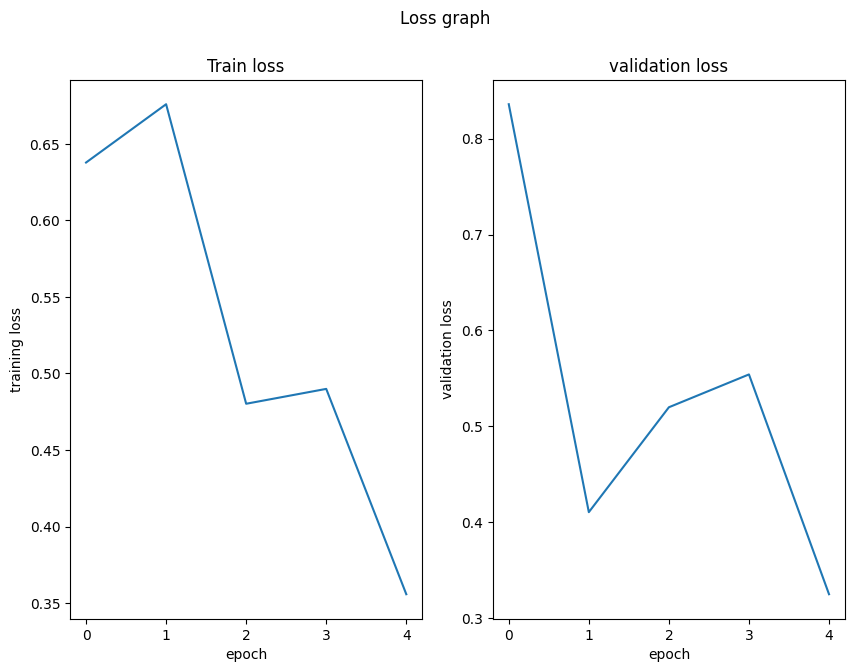

In [57]:
cls.graph()

In [131]:
cls.model.eval()
encoded = cls.tokenizer("Hey it's a very caca prout movie", truncation=True, padding=True, return_tensors="pt")

In [132]:
with torch.no_grad() :
    outputs = cls.model(input_ids = encoded["input_ids"], attention_mask=encoded["attention_mask"])

In [133]:
outputs.logits

tensor([[-0.0486,  0.0719]])

In [134]:
classe =  np.argmax(outputs.logits.numpy()[0])
if classe == 1 : print("good")
else : print("bad")

good


To achieve an 80/10/10 split of the data for training, validation, and testing, we divide the data into three datasets.